In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve, f1_score, roc_auc_score
from sklearn import linear_model, model_selection, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder
import json
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
gossipcop_data = json.load(open("gdrive/MyDrive/BT4222/Data/gossipcop_clean.json", "r"))
gossipcop_clean = pd.DataFrame(gossipcop_data)

In [4]:
#cleaning the csv, filtering out NA values for text column and replacing NA values for title and publisher
gossipcop_clean = gossipcop_clean[gossipcop_clean['text_clean'].notna()]
gossipcop_clean['title_clean'] = gossipcop_clean['title_clean'].fillna('none')
gossipcop_clean['publisher'] = gossipcop_clean['publisher'].fillna('none')
gossipcop_clean['title_clean'] = gossipcop_clean['title_clean'].str.replace(r'[^\x00-\x7F]+', '') 

#description + headline as another column
gossipcop_clean['text_and_title'] = gossipcop_clean['text_clean'] + ' '+ gossipcop_clean['title_clean']

# examine the first row
gossipcop_clean.head(3)
#politifact_clean.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,id,text,title,publish_date,source,url,publisher,published_time,dataset,label,title_clean,text_clean,text_and_title
0,gossipcop-5181890716,Three’s company! Jamie Foxx is jeopardizing hi...,Jamie Foxx's Ex Is Threatening His Relationshi...,1.519837e+09,http://www.intouchweekly.com,https://www.intouchweekly.com/posts/jamie-foxx...,In Touch Weekly,2018-02-28T17:00:00+00:00,gossipcop,fake,jamie foxx ex threaten relationship katie holmes,company jamie foxx jeopardize relationship lon...,company jamie foxx jeopardize relationship lon...
1,gossipcop-5005633749,The INSIDER Summary:\n\nKim Kardashian will re...,Kim Kardashian will not be attending Paris Fas...,1.506355e+09,http://www.businessinsider.com,http://hollywoodlife.com/2017/09/26/kim-kardas...,Business Insider,NaN,gossipcop,fake,kim kardashian attend paris fashion week year,insider summary kim kardashian reportedly atte...,insider summary kim kardashian reportedly atte...
2,gossipcop-2661113454,"(CNN) -- It may be a case of wishful thinking,...",Is Kim Kardashian pursuing a music career?,1.403021e+09,http://www.cnn.com,http://www.cnn.com/2014/06/18/showbiz/celebrit...,CNN,NaN,gossipcop,fake,kim kardashian pursue music career,cnn -- case wishful thinking british tabloid r...,cnn -- case wishful thinking british tabloid r...


# SVM

In [5]:
SVM_dict_a = dict()
SVM_dict_b = dict()
SVM_dict_c = dict()
def tokenize_test_SVM(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use SVM to predict fake vs real
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train_dtm, y_train)
    y_pred_class = SVM.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

### text feature

In [6]:
#TD-IDF
X = gossipcop_clean.text_clean
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  81467
Accuracy:  0.8580452127659575
F1 score:  0.9121579921826785
              precision    recall  f1-score   support

        fake       0.82      0.51      0.63       712
        real       0.86      0.97      0.91      2296

    accuracy                           0.86      3008
   macro avg       0.84      0.74      0.77      3008
weighted avg       0.85      0.86      0.85      3008



In [7]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_a['CV'] = [accuracy, fscore]

Features:  81467
Accuracy:  0.7822473404255319
F1 score:  0.8565169769989047
              precision    recall  f1-score   support

        fake       0.54      0.56      0.55       712
        real       0.86      0.85      0.86      2296

    accuracy                           0.78      3008
   macro avg       0.70      0.71      0.70      3008
weighted avg       0.79      0.78      0.78      3008



### title + text feature

In [8]:
#TD-IDF
X = gossipcop_clean.text_and_title
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  81747
Accuracy:  0.8643617021276596
F1 score:  0.9155279503105591
              precision    recall  f1-score   support

        fake       0.82      0.55      0.66       712
        real       0.87      0.96      0.92      2296

    accuracy                           0.86      3008
   macro avg       0.85      0.75      0.79      3008
weighted avg       0.86      0.86      0.85      3008



In [9]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_SVM(vect, X_train, y_train, X_test, y_test)
SVM_dict_b['CV'] = [accuracy, fscore]

Features:  81747
Accuracy:  0.7882313829787234
F1 score:  0.8584758942457232
              precision    recall  f1-score   support

        fake       0.55      0.62      0.58       712
        real       0.88      0.84      0.86      2296

    accuracy                           0.79      3008
   macro avg       0.71      0.73      0.72      3008
weighted avg       0.80      0.79      0.79      3008



# Logistic Regression

In [10]:
LR_dict_a = dict()
LR_dict_b = dict()
LR_dict_c = dict()
def tokenize_test_LogR(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Logistic Regression to predict fake vs real
    LogR = LogisticRegression()
    LogR.fit(X_train_dtm, y_train)
    y_pred_class = LogR.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

### text feature

In [11]:
#TD-IDF
X = gossipcop_clean.text_clean
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  81467
Accuracy:  0.855718085106383
F1 score:  0.9116089613034624
              precision    recall  f1-score   support

        fake       0.85      0.47      0.61       712
        real       0.86      0.97      0.91      2296

    accuracy                           0.86      3008
   macro avg       0.85      0.72      0.76      3008
weighted avg       0.86      0.86      0.84      3008



In [12]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_a['CV'] = [accuracy, fscore]

Features:  81467


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy:  0.8201462765957447
F1 score:  0.8839304870199527
              precision    recall  f1-score   support

        fake       0.63      0.57      0.60       712
        real       0.87      0.90      0.88      2296

    accuracy                           0.82      3008
   macro avg       0.75      0.73      0.74      3008
weighted avg       0.81      0.82      0.82      3008



### title + text feature

In [13]:
#TD-IDF
X = gossipcop_clean.text_and_title
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  81747
Accuracy:  0.8610372340425532
F1 score:  0.9143091430914309
              precision    recall  f1-score   support

        fake       0.85      0.51      0.63       712
        real       0.86      0.97      0.91      2296

    accuracy                           0.86      3008
   macro avg       0.85      0.74      0.77      3008
weighted avg       0.86      0.86      0.85      3008



In [14]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_LogR(vect, X_train, y_train, X_test, y_test)
LR_dict_b['CV'] = [accuracy, fscore]

Features:  81747


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy:  0.824468085106383
F1 score:  0.8858131487889274
              precision    recall  f1-score   support

        fake       0.64      0.61      0.62       712
        real       0.88      0.89      0.89      2296

    accuracy                           0.82      3008
   macro avg       0.76      0.75      0.75      3008
weighted avg       0.82      0.82      0.82      3008



# Naive Bayes

In [15]:
NB_dict_a = dict()
NB_dict_b = dict()
NB_dict_c = dict()
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_NB(vect, X_train, y_train, X_test, y_test):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features: ', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to predict fake vs real
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    #print(y_pred_class)
    
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred_class, labels=['fake', 'real'])
    matrix = classification_report(y_test, y_pred_class, labels=['fake', 'real'])
    
    global accuracy, fscore
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    fscore = metrics.f1_score(y_test, y_pred_class, pos_label='real')
    # print the accuracy of its predictions
    print('Accuracy: ', accuracy)
    print('F1 score: ', fscore)
    print(matrix)

### text feature

In [18]:
#TD-IDF
X = gossipcop_clean.text_clean
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_a['TD-IDF'] = [accuracy, fscore]

Features:  81467
Accuracy:  0.7782579787234043
F1 score:  0.8731698041452748
              precision    recall  f1-score   support

        fake       1.00      0.06      0.12       712
        real       0.77      1.00      0.87      2296

    accuracy                           0.78      3008
   macro avg       0.89      0.53      0.50      3008
weighted avg       0.83      0.78      0.69      3008



In [19]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_a['CV'] = [accuracy, fscore]

Features:  81467
Accuracy:  0.8075132978723404
F1 score:  0.8722136393732068
              precision    recall  f1-score   support

        fake       0.59      0.64      0.61       712
        real       0.88      0.86      0.87      2296

    accuracy                           0.81      3008
   macro avg       0.74      0.75      0.74      3008
weighted avg       0.81      0.81      0.81      3008



### title + text feature

In [16]:
#TD-IDF
X = gossipcop_clean.text_and_title
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

vect = TfidfVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_b['TD-IDF'] = [accuracy, fscore]

Features:  81747
Accuracy:  0.7862367021276596
F1 score:  0.8771259315879992
              precision    recall  f1-score   support

        fake       0.99      0.10      0.18       712
        real       0.78      1.00      0.88      2296

    accuracy                           0.79      3008
   macro avg       0.88      0.55      0.53      3008
weighted avg       0.83      0.79      0.71      3008



In [17]:
#CountVectorizer
vect = CountVectorizer()
tokenize_test_NB(vect, X_train, y_train, X_test, y_test)
NB_dict_b['CV'] = [accuracy, fscore]

Features:  81747
Accuracy:  0.8141622340425532
F1 score:  0.8750279454504807
              precision    recall  f1-score   support

        fake       0.59      0.69      0.64       712
        real       0.90      0.85      0.88      2296

    accuracy                           0.81      3008
   macro avg       0.75      0.77      0.76      3008
weighted avg       0.83      0.81      0.82      3008



# Evaluation metric: AU-ROC 

In [20]:
roc_auc_scores = []
#defining a function to plot the AU-ROC curve for each X
def compare_au_roc(vect, X_train, y_train, X_test, y_test):
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    lr = LogisticRegression()
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
    nb = MultinomialNB()
    
    lr.fit(X_train_dtm, y_train)
    SVM.fit(X_train_dtm, y_train)
    nb.fit(X_train_dtm, y_train)
    y_pred_nb = nb.predict_proba(X_test_dtm)
    y_pred_svm = SVM.predict_proba(X_test_dtm)
    y_pred_lr = lr.predict_proba(X_test_dtm)
    
    global score_svm, score_lr, score_nb
    score_nb = roc_auc_score(y_test, y_pred_nb[:,1], multi_class='ovo')
    score_svm = roc_auc_score(y_test, y_pred_svm[:,1], multi_class='ovo')
    score_lr = roc_auc_score(y_test, y_pred_lr[:,1], multi_class='ovo')
    disp = plot_roc_curve(lr, X_test_dtm, y_test)
    plot_roc_curve(SVM, X_test_dtm, y_test, ax=disp.ax_)
    plot_roc_curve(nb, X_test_dtm, y_test, ax=disp.ax_)

In [21]:
X = gossipcop_clean.text_clean
y = gossipcop_clean.label
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

X1 = gossipcop_clean.text_and_title
y1 = gossipcop_clean.label
X1_train, X1_rest, y1_train, y1_rest = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_rest, y1_rest, test_size=0.5, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

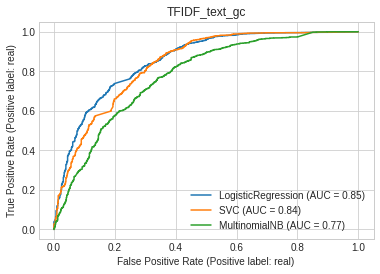

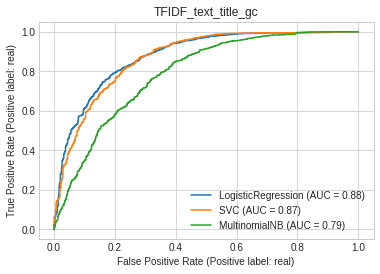

In [22]:
#TFIDF
compare_au_roc(TfidfVectorizer(), X_train, y_train, X_test, y_test) #text_clean
plt.title('TFIDF_text_gc')
plt.savefig('TFIDF_text_gc')
files.download('TFIDF_text_gc.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc(TfidfVectorizer(), X1_train, y1_train, X1_test, y1_test) #text_and_title
plt.title('TFIDF_text_title_gc')
plt.savefig('TFIDF_text_title_gc')
files.download('TFIDF_text_title_gc.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: Futur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: Futur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

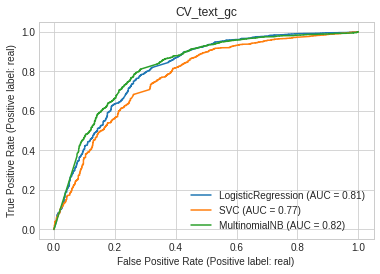

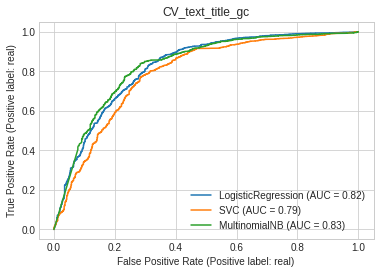

In [23]:
#Count Vectorizer
compare_au_roc(CountVectorizer(), X_train, y_train, X_test, y_test) #text_clean
plt.title('CV_text_gc')
plt.savefig('CV_text_gc')
files.download('CV_text_gc.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)
compare_au_roc(CountVectorizer(), X1_train, y1_train, X1_test, y1_test) #text_and_title
plt.title('CV_text_title_gc')
plt.savefig('CV_text_title_gc')
files.download('CV_text_title_gc.png')
roc_auc_scores.append(score_svm)
roc_auc_scores.append(score_lr)
roc_auc_scores.append(score_nb)

# Scatterplot of Accuracy against F1-score

In [ ]:
def plot_scatterplot(NB_dict, LR_dict, SVM_dict):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    plt.xlabel('Accuracy')
    plt.ylabel('F1 score')
    count = 0
    for x, y in NB_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="s", c="r", label="NB_TFIDF")
        else:
            ax1.scatter(x, y, marker="s", c="b", label="NB_CV")
        count+=1
    count = 0
    for x, y in LR_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="o", c="r", label="LR_TFIDF")
        else:
            ax1.scatter(x, y, marker="o", c="b", label="LR_CV")
        count+=1
    count = 0
    for x, y in SVM_dict.values():
        if count == 0:
            ax1.scatter(x, y, marker="^", c="r", label="SVM_TFIDF")
        else:
            ax1.scatter(x, y, marker="^", c="b", label="SVM_CV")
        count+=1
    plt.legend(fontsize = 8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

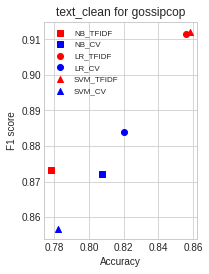

In [ ]:
#text_clean
plot_scatterplot(NB_dict_a, LR_dict_a, SVM_dict_a)
plt.title('text_clean for gossipcop')
plt.savefig('Scatterplot_a_gc.png')
#files.download("Scatterplot_a_gc.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

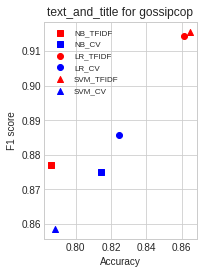

In [ ]:
#text_and_title
plot_scatterplot(NB_dict_b, LR_dict_b, SVM_dict_b)
plt.title('text_and_title for gossipcop')
plt.savefig('Scatterplot_b_gc.png')
#files.download("Scatterplot_b_gc.png") 

# Writing accuracy values into a dataframe

In [ ]:
acc_scores = []

for acc, f1 in SVM_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in SVM_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in SVM_dict_c.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in LR_dict_c.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_a.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_b.values():
    acc_scores.append(acc)
for acc, f1 in NB_dict_c.values():
    acc_scores.append(acc)
print(acc_scores)

[0.8580452127659575, 0.7822473404255319, 0.8643617021276596, 0.7882313829787234, 0.855718085106383, 0.8201462765957447, 0.8610372340425532, 0.824468085106383, 0.7782579787234043, 0.8075132978723404, 0.7862367021276596, 0.8141622340425532]


In [ ]:
features = ['ML methods', 'text TF-IDF', 'text Count Vectorizer',  
            'text_and_title TF-IDF', 'text_and_title Count Vectorizer',]

In [ ]:
acc_matrix = pd.DataFrame(columns = features)
acc_matrix.loc[0] = ['SVM'] + acc_scores[:4]
acc_matrix.loc[1] = ['Logistic Regression'] + acc_scores[4:8]
acc_matrix.loc[2] = ['Naive Bayes'] + acc_scores[8:]
acc_matrix
#acc_matrix.to_csv('Accuracy_gc.csv', encoding = 'utf-8-sig') 
#files.download('Accuracy_gc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
f1_scores = []

for acc, f1 in SVM_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in SVM_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in SVM_dict_c.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in LR_dict_c.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_a.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_b.values():
    f1_scores.append(f1)
for acc, f1 in NB_dict_c.values():
    f1_scores.append(f1)

In [ ]:
f1_matrix = pd.DataFrame(columns = features)
f1_matrix.loc[0] = ['SVM'] + f1_scores[:4]
f1_matrix.loc[1] = ['Logistic Regression'] + f1_scores[4:8]
f1_matrix.loc[2] = ['Naive Bayes'] + f1_scores[8:]
f1_matrix
#f1_matrix.to_csv('f1_scores_gc.csv', encoding = 'utf-8-sig') 
#files.download('f1_scores_gc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
auc_matrix = pd.DataFrame(columns = ['Features and vect','SVM', 'Logistic Regression', 'Naive Bayes'])
auc_matrix.loc[0] = ['text TF-IDF'] + roc_auc_scores[:3]
auc_matrix.loc[1] = ['text_and_title TF-IDF'] + roc_auc_scores[3:6]
auc_matrix.loc[3] = ['text Count Vectorizer'] + roc_auc_scores[6:9]
auc_matrix.loc[4] = ['text_and_title Count Vectorizer'] + roc_auc_scores[9:]

#auc_matrix.to_csv('ROC_AUC_scores_gc.csv', encoding = 'utf-8-sig') 
#files.download('ROC_AUC_scores_gc.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(auc_matrix)

                 Features and vect       SVM  Logistic Regression  Naive Bayes
0                      text TF-IDF  0.836164             0.853727     0.774682
1            text_and_title TF-IDF  0.870452             0.878637     0.788151
3            text Count Vectorizer  0.771987             0.808686     0.819767
4  text_and_title Count Vectorizer  0.788041             0.821882     0.827839
